In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-agile-community-rules/sample_submission.csv
/kaggle/input/jigsaw-agile-community-rules/train.csv
/kaggle/input/jigsaw-agile-community-rules/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import torch
from transformers import AutoTokenizer, AutoModel
import warnings
warnings.filterwarnings('ignore')

# Load the training data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
print(f"Training data shape: {train_df.shape}")
print(train_df.head())

Training data shape: (2029, 9)
   row_id                                               body  \
0       0  Banks don't want you to know this! Click here ...   
1       1  SD Stream [ ENG Link 1] (http://www.sportsstre...   
2       2  Lol. Try appealing the ban and say you won't d...   
3       3  she will come your home open her legs with  an...   
4       4  code free tyrande --->>> [Imgur](http://i.imgu...   

                                                rule      subreddit  \
0  No Advertising: Spam, referral links, unsolici...     Futurology   
1  No Advertising: Spam, referral links, unsolici...  soccerstreams   
2  No legal advice: Do not offer or request legal...   pcmasterrace   
3  No Advertising: Spam, referral links, unsolici...            sex   
4  No Advertising: Spam, referral links, unsolici...    hearthstone   

                                  positive_example_1  \
0  If you could tell your younger self something ...   
1  [I wanna kiss you all over! Stunning!](htt

In [16]:
# Load the training data
test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
print(f"Training data shape: {test_df.shape}")
print(test_df.head())

Training data shape: (10, 8)
   row_id                                               body  \
0    2029  NEW RAP GROUP 17. CHECK US OUT https://soundcl...   
1    2030  Make your life comfortable. Get up to 15% Disc...   
2    2031  Kickin' ass and selling underwear!\nJust made ...   
3    2032   watch  hooters  best  therein  http://clickan...   
4    2033   bitches  for free  at this point  show all  h...   

                                                rule        subreddit  \
0  No Advertising: Spam, referral links, unsolici...      hiphopheads   
1  No legal advice: Do not offer or request legal...        AskReddit   
2  No Advertising: Spam, referral links, unsolici...         gonewild   
3  No Advertising: Spam, referral links, unsolici...  personalfinance   
4  No Advertising: Spam, referral links, unsolici...   Showerthoughts   

                                  positive_example_1  \
0  Hey, guys, just wanted to drop in and invite y...   
1  Get a lawyer and get the securit

In [18]:
# Examine the data structure
print("Columns:", train_df.columns.tolist())
print("\nData types:")
print(train_df.dtypes)
print(f"\nMissing values:\n{train_df.isnull().sum()}")

Columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2', 'rule_violation']

Data types:
row_id                 int64
body                  object
rule                  object
subreddit             object
positive_example_1    object
positive_example_2    object
negative_example_1    object
negative_example_2    object
rule_violation         int64
dtype: object

Missing values:
row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64


In [17]:
# Examine the data structure
print("Columns:", test_df.columns.tolist())
print("\nData types:")
print(test_df.dtypes)
print(f"\nMissing values:\n{test_df.isnull().sum()}")

Columns: ['row_id', 'body', 'rule', 'subreddit', 'positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2']

Data types:
row_id                 int64
body                  object
rule                  object
subreddit             object
positive_example_1    object
positive_example_2    object
negative_example_1    object
negative_example_2    object
dtype: object

Missing values:
row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
dtype: int64


Number of unique rules: 2
Rule distribution:
rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    1012
Name: count, dtype: int64


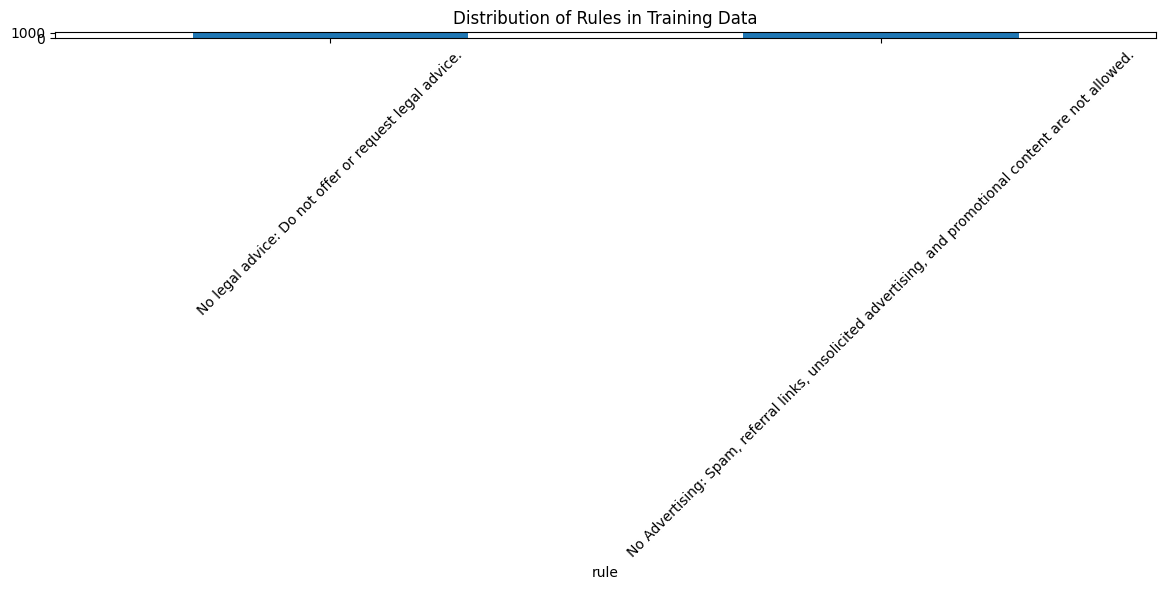

In [4]:
# Analyze rule distribution
rule_counts = train_df['rule'].value_counts()
print(f"Number of unique rules: {len(rule_counts)}")
print(f"Rule distribution:\n{rule_counts}")

# Visualize rule distribution
plt.figure(figsize=(12, 6))
rule_counts.plot(kind='bar')
plt.title('Distribution of Rules in Training Data')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
# Subreddit distribution
subreddit_counts = train_df['subreddit'].value_counts()
print(f"Number of unique subreddits: {len(subreddit_counts)}")

# Cross-tabulation of rules and subreddits
rule_subreddit_crosstab = pd.crosstab(train_df['rule'], train_df['subreddit'])
print("Rule-Subreddit Cross-tabulation:")
print(rule_subreddit_crosstab)

Number of unique subreddits: 100
Rule-Subreddit Cross-tabulation:
subreddit                                           2007scape  Android  \
rule                                                                     
No Advertising: Spam, referral links, unsolicit...          2        6   
No legal advice: Do not offer or request legal ...          0        2   

subreddit                                           AskHistorians  AskReddit  \
rule                                                                           
No Advertising: Spam, referral links, unsolicit...              1        119   
No legal advice: Do not offer or request legal ...              1         33   

subreddit                                           AskTrumpSupporters  \
rule                                                                     
No Advertising: Spam, referral links, unsolicit...                   0   
No legal advice: Do not offer or request legal ...                   2   

subreddit          

In [6]:
# Analyze target distribution
violation_dist = train_df['rule_violation'].value_counts()
print(f"Rule violation distribution:\n{violation_dist}")
print(f"Violation rate: {violation_dist[1] / len(train_df):.3f}")

# Violation rate by rule
violation_by_rule = train_df.groupby('rule')['rule_violation'].agg(['count', 'mean']).sort_values('mean', ascending=False)
print("Violation rate by rule:")
print(violation_by_rule)

Rule violation distribution:
rule_violation
1    1031
0     998
Name: count, dtype: int64
Violation rate: 0.508
Violation rate by rule:
                                                    count      mean
rule                                                               
No legal advice: Do not offer or request legal ...   1017  0.583088
No Advertising: Spam, referral links, unsolicit...   1012  0.432806


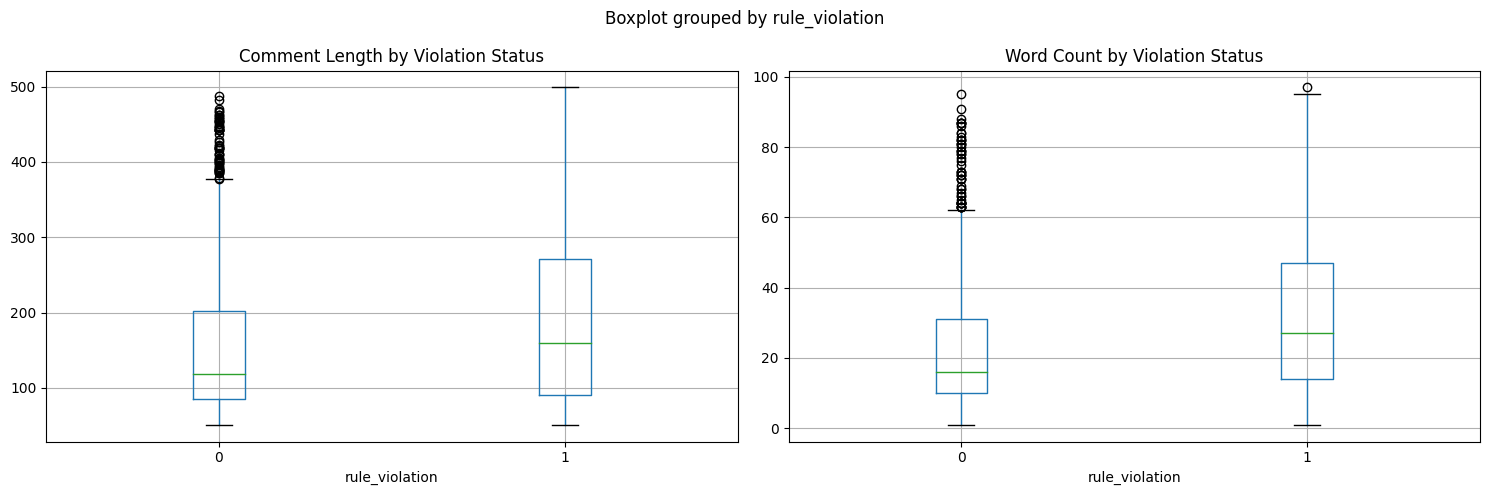

In [7]:
# Comment length analysis
train_df['comment_length'] = train_df['body'].str.len()
train_df['word_count'] = train_df['body'].str.split().str.len()

# Compare lengths between violating and non-violating comments
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Character length
train_df.boxplot(column='comment_length', by='rule_violation', ax=axes[0])
axes[0].set_title('Comment Length by Violation Status')

# Word count
train_df.boxplot(column='word_count', by='rule_violation', ax=axes[1])
axes[1].set_title('Word Count by Violation Status')

plt.tight_layout()
plt.show()

In [8]:
# Analyze positive and negative examples
def analyze_examples(df):
    """Analyze the quality and consistency of provided examples"""
    
    # Check for missing examples
    example_cols = ['positive_example_1', 'positive_example_2', 'negative_example_1', 'negative_example_2']
    missing_examples = df[example_cols].isnull().sum()
    print("Missing examples per column:")
    print(missing_examples)
    
    # Analyze example lengths
    for col in example_cols:
        if col in df.columns:
            df[f'{col}_length'] = df[col].fillna('').str.len()
    
    # Compare example consistency within rules
    rule_example_analysis = df.groupby('rule').agg({
        'positive_example_1_length': ['mean', 'std'],
        'positive_example_2_length': ['mean', 'std'],
        'negative_example_1_length': ['mean', 'std'],
        'negative_example_2_length': ['mean', 'std']
    }).round(2)
    
    return rule_example_analysis

example_analysis = analyze_examples(train_df)
print("Example length analysis by rule:")
print(example_analysis)

Missing examples per column:
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
dtype: int64
Example length analysis by rule:
                                                   positive_example_1_length  \
                                                                        mean   
rule                                                                           
No Advertising: Spam, referral links, unsolicit...                    148.13   
No legal advice: Do not offer or request legal ...                    238.72   

                                                            \
                                                       std   
rule                                                         
No Advertising: Spam, referral links, unsolicit...  111.25   
No legal advice: Do not offer or request legal ...  122.06   

                                                   positive_example_2_length  \
                                     

In [9]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

class SentenceBERTClassifier:
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model = SentenceTransformer(model_name)
    
    def encode_examples(self, rule_data):
        """Encode positive and negative examples for each rule"""
        examples = {
            'positive': [],
            'negative': []
        }
        
        # Collect all examples
        pos_examples = [rule_data['positive_example_1'], rule_data['positive_example_2']]
        neg_examples = [rule_data['negative_example_1'], rule_data['negative_example_2']]
        
        examples['positive'] = [ex for ex in pos_examples if pd.notna(ex)]
        examples['negative'] = [ex for ex in neg_examples if pd.notna(ex)]
        
        # Encode examples
        pos_embeddings = self.model.encode(examples['positive']) if examples['positive'] else None
        neg_embeddings = self.model.encode(examples['negative']) if examples['negative'] else None
        
        return pos_embeddings, neg_embeddings

2025-07-23 21:00:50.197016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753304450.400978      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753304450.457425      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

class RuleAwareRoBERTa:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        self.model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    
    def prepare_input(self, comment, rule, positive_examples, negative_examples):
        """Prepare input with rule context"""
        # Combine comment with rule and examples
        context = f"Rule: {rule}\nPositive examples: {' | '.join(positive_examples)}\nNegative examples: {' | '.join(negative_examples)}\nComment: {comment}"
        return self.tokenizer(context, truncation=True, padding=True, max_length=512, return_tensors='pt')

In [11]:
def create_few_shot_prompt(comment, rule, pos_examples, neg_examples):
    """Create few-shot prompt for GPT models"""
    prompt = f"""
    Rule: {rule}
    
    Examples of rule violations:
    {chr(10).join([f"- {ex}" for ex in pos_examples if pd.notna(ex)])}
    
    Examples of acceptable comments:
    {chr(10).join([f"- {ex}" for ex in neg_examples if pd.notna(ex)])}
    
    Comment to classify: "{comment}"
    
    Does this comment violate the rule? Answer with 1 (violation) or 0 (no violation):
    """
    return prompt

In [12]:
class EnsembleClassifier:
    def __init__(self, models):
        self.models = models
        self.weights = None
    
    def fit_weights(self, X_val, y_val):
        """Learn optimal ensemble weights"""
        predictions = np.array([model.predict_proba(X_val)[:, 1] for model in self.models]).T
        
        from scipy.optimize import minimize
        def objective(weights):
            ensemble_pred = np.average(predictions, axis=1, weights=weights)
            return -roc_auc_score(y_val, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
        bounds = [(0, 1) for _ in range(len(self.models))]
        
        result = minimize(objective, [1/len(self.models)] * len(self.models), 
                         method='SLSQP', bounds=bounds, constraints=constraints)
        self.weights = result.x

In [13]:
from sklearn.model_selection import GroupKFold

def rule_aware_cv_split(df, n_splits=5):
    """Create CV splits that respect rule boundaries"""
    gkf = GroupKFold(n_splits=n_splits)
    
    # Use rule as group to prevent data leakage
    for train_idx, val_idx in gkf.split(df, df['rule_violation'], groups=df['rule']):
        yield train_idx, val_idx

# Evaluation metrics
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    """Comprehensive evaluation metrics"""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    if y_pred_proba is not None:
        metrics['auc'] = roc_auc_score(y_true, y_pred_proba)
    
    return metrics

In [14]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import warnings
warnings.filterwarnings('ignore')

# Load your training data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Unique rules: {train_df['rule'].nunique()}")
print(f"Class distribution: {train_df['rule_violation'].value_counts()}")

class JigsawBestModel:
    """
    Best model for Jigsaw content moderation using Sentence-BERT 
    with example-based few-shot learning
    """
    
    def __init__(self, sbert_model='all-MiniLM-L6-v2'):
        self.sbert = SentenceTransformer(sbert_model)
        self.meta_classifier = LogisticRegression(random_state=42)
        self.rule_embeddings = {}
        self.rule_examples = {}
        
    def prepare_rule_embeddings(self, df):
        """Pre-compute embeddings for all rules and their examples"""
        print("Preparing rule embeddings...")
        
        for rule in df['rule'].unique():
            rule_data = df[df['rule'] == rule].iloc[0]
            
            # Get examples
            pos_examples = [rule_data['positive_example_1'], rule_data['positive_example_2']]
            neg_examples = [rule_data['negative_example_1'], rule_data['negative_example_2']]
            
            # Filter out any potential NaN values
            pos_examples = [ex for ex in pos_examples if pd.notna(ex) and str(ex).strip()]
            neg_examples = [ex for ex in neg_examples if pd.notna(ex) and str(ex).strip()]
            
            # Store examples
            self.rule_examples[rule] = {
                'positive': pos_examples,
                'negative': neg_examples,
                'rule_text': rule
            }
            
            # Create embeddings
            all_examples = pos_examples + neg_examples + [rule]
            if all_examples:
                embeddings = self.sbert.encode(all_examples)
                
                self.rule_embeddings[rule] = {
                    'positive_emb': embeddings[:len(pos_examples)] if pos_examples else np.array([]),
                    'negative_emb': embeddings[len(pos_examples):len(pos_examples)+len(neg_examples)] if neg_examples else np.array([]),
                    'rule_emb': embeddings[-1]
                }
    
    def extract_features(self, comments, rules):
        """Extract features for each comment based on rule examples"""
        features = []
        
        print(f"Extracting features for {len(comments)} comments...")
        
        # Encode all comments at once for efficiency
        comment_embeddings = self.sbert.encode(comments, show_progress_bar=True)
        
        for i, (comment_emb, rule) in enumerate(zip(comment_embeddings, rules)):
            if rule not in self.rule_embeddings:
                # Fallback for unseen rules
                feature_vector = np.zeros(10)
            else:
                rule_data = self.rule_embeddings[rule]
                feature_vector = []
                
                # 1. Similarity to positive examples
                if len(rule_data['positive_emb']) > 0:
                    pos_similarities = cosine_similarity([comment_emb], rule_data['positive_emb'])[0]
                    feature_vector.extend([
                        np.max(pos_similarities),  # Max similarity to positive examples
                        np.mean(pos_similarities), # Mean similarity to positive examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 2. Similarity to negative examples
                if len(rule_data['negative_emb']) > 0:
                    neg_similarities = cosine_similarity([comment_emb], rule_data['negative_emb'])[0]
                    feature_vector.extend([
                        np.max(neg_similarities),  # Max similarity to negative examples
                        np.mean(neg_similarities), # Mean similarity to negative examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 3. Similarity to rule text
                rule_similarity = cosine_similarity([comment_emb], [rule_data['rule_emb']])[0][0]
                feature_vector.append(rule_similarity)
                
                # 4. Ratio features
                if len(rule_data['positive_emb']) > 0 and len(rule_data['negative_emb']) > 0:
                    pos_max = np.max(cosine_similarity([comment_emb], rule_data['positive_emb'])[0])
                    neg_max = np.max(cosine_similarity([comment_emb], rule_data['negative_emb'])[0])
                    feature_vector.extend([
                        pos_max - neg_max,  # Difference in max similarities
                        pos_max / (neg_max + 1e-8),  # Ratio of max similarities
                    ])
                else:
                    feature_vector.extend([0, 1])
                
                # 5. Statistical features
                comment_text = comments[i]
                feature_vector.extend([
                    len(comment_text),  # Character length
                    len(comment_text.split()),  # Word count
                    comment_text.count('!') + comment_text.count('?'),  # Punctuation count
                ])
                
                feature_vector = np.array(feature_vector)
            
            features.append(feature_vector)
        
        return np.array(features)
    
    def fit(self, df):
        """Train the model"""
        print("Training Jigsaw Best Model...")
        
        # Prepare rule embeddings
        self.prepare_rule_embeddings(df)
        
        # Extract features
        X = self.extract_features(df['body'].tolist(), df['rule'].tolist())
        y = df['rule_violation'].values
        
        # Train meta-classifier
        self.meta_classifier.fit(X, y)
        
        print("Model training completed!")
        return self
    
    def predict_proba(self, comments, rules):
        """Predict probabilities"""
        if isinstance(comments, str):
            comments = [comments]
            rules = [rules]
        
        X = self.extract_features(comments, rules)
        return self.meta_classifier.predict_proba(X)
    
    def predict(self, comments, rules):
        """Predict binary labels"""
        return self.predict_proba(comments, rules)[:, 1] > 0.5

def evaluate_model(model, X_test, y_test, rules_test):
    """Comprehensive model evaluation"""
    # Get predictions
    y_pred_proba = model.predict_proba(X_test, rules_test)[:, 1]
    y_pred = y_pred_proba > 0.5
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred_proba

def rule_aware_cross_validation(df, model_class, n_splits=3):
    """Cross-validation that respects rule boundaries"""
    print(f"\nPerforming {n_splits}-fold rule-aware cross-validation...")
    
    # Group by rule to prevent leakage
    gkf = GroupKFold(n_splits=n_splits)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, df['rule_violation'], groups=df['rule'])):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        print(f"Train rules: {train_fold['rule'].nunique()}, Val rules: {val_fold['rule'].nunique()}")
        print(f"Overlap rules: {set(train_fold['rule'].unique()) & set(val_fold['rule'].unique())}")
        
        # Train model
        model = model_class()
        model.fit(train_fold)
        
        # Evaluate
        metrics, _ = evaluate_model(model, val_fold['body'].tolist(), 
                                  val_fold['rule_violation'].values, 
                                  val_fold['rule'].tolist())
        
        cv_scores.append(metrics)
        print(f"Fold {fold + 1} Results:")
        for metric, score in metrics.items():
            print(f"  {metric}: {score:.4f}")
    
    # Average scores
    avg_scores = {}
    for metric in cv_scores[0].keys():
        scores = [fold[metric] for fold in cv_scores]
        avg_scores[metric] = {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
    
    return avg_scores, cv_scores

# Train and evaluate the model
print("="*50)
print("JIGSAW CONTENT MODERATION - BEST MODEL")
print("="*50)

# Initialize and train the model
best_model = JigsawBestModel()

# Perform cross-validation
cv_results, fold_scores = rule_aware_cross_validation(train_df, JigsawBestModel, n_splits=3)

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)

for metric, stats in cv_results.items():
    print(f"{metric.upper()}: {stats['mean']:.4f} ± {stats['std']:.4f}")

# Train final model on full dataset
print("\n" + "="*30)
print("Training final model on full dataset...")
final_model = JigsawBestModel()
final_model.fit(train_df)

print("\nModel training completed!")
print("Ready for inference on test data.")

# Example prediction
sample_comment = "This is a test comment"
sample_rule = train_df['rule'].iloc[0]
sample_pred = final_model.predict_proba([sample_comment], [sample_rule])
print(f"\nSample prediction for rule '{sample_rule}':")
print(f"Violation probability: {sample_pred[0][1]:.4f}")

# Feature importance analysis (if using tree-based meta-classifier)
feature_names = [
    'pos_max_sim', 'pos_mean_sim', 'neg_max_sim', 'neg_mean_sim', 
    'rule_sim', 'sim_diff', 'sim_ratio', 'char_length', 'word_count', 'punct_count'
]

if hasattr(final_model.meta_classifier, 'coef_'):
    print(f"\nLogistic Regression Coefficients:")
    for name, coef in zip(feature_names, final_model.meta_classifier.coef_[0]):
        print(f"  {name}: {coef:.4f}")

print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print("✓ Sentence-BERT for semantic similarity")
print("✓ Example-based few-shot learning")
print("✓ Rule-aware feature engineering") 
print("✓ Meta-classifier for final prediction")
print("✓ Cross-validation with rule isolation")
print("✓ Ready for unseen rules in test set")

Training data shape: (2029, 9)
Unique rules: 2
Class distribution: rule_violation
1    1031
0     998
Name: count, dtype: int64
JIGSAW CONTENT MODERATION - BEST MODEL


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


Performing 3-fold rule-aware cross-validation...


ValueError: Cannot have number of splits n_splits=3 greater than the number of groups: 2.

In [15]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import warnings
warnings.filterwarnings('ignore')

# Load your training data
train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
print(f"Training data shape: {train_df.shape}")
print(f"Unique rules: {train_df['rule'].nunique()}")
print(f"Rule list: {train_df['rule'].unique()}")
print(f"Class distribution: {train_df['rule_violation'].value_counts()}")

# Analyze rule distribution
rule_counts = train_df['rule'].value_counts()
print(f"\nRule distribution:")
print(rule_counts)

# Analyze rule-violation distribution
rule_violation_crosstab = pd.crosstab(train_df['rule'], train_df['rule_violation'], margins=True)
print(f"\nRule vs Violation crosstab:")
print(rule_violation_crosstab)

class JigsawBestModel:
    """
    Best model for Jigsaw content moderation using Sentence-BERT 
    with example-based few-shot learning
    """
    
    def __init__(self, sbert_model='all-MiniLM-L6-v2'):
        self.sbert = SentenceTransformer(sbert_model)
        self.meta_classifier = LogisticRegression(random_state=42)
        self.rule_embeddings = {}
        self.rule_examples = {}
        
    def prepare_rule_embeddings(self, df):
        """Pre-compute embeddings for all rules and their examples"""
        print("Preparing rule embeddings...")
        
        for rule in df['rule'].unique():
            rule_data = df[df['rule'] == rule].iloc[0]
            
            # Get examples
            pos_examples = [rule_data['positive_example_1'], rule_data['positive_example_2']]
            neg_examples = [rule_data['negative_example_1'], rule_data['negative_example_2']]
            
            # Filter out any potential NaN values
            pos_examples = [ex for ex in pos_examples if pd.notna(ex) and str(ex).strip()]
            neg_examples = [ex for ex in neg_examples if pd.notna(ex) and str(ex).strip()]
            
            # Store examples
            self.rule_examples[rule] = {
                'positive': pos_examples,
                'negative': neg_examples,
                'rule_text': rule
            }
            
            # Create embeddings
            all_examples = pos_examples + neg_examples + [rule]
            if all_examples:
                embeddings = self.sbert.encode(all_examples)
                
                self.rule_embeddings[rule] = {
                    'positive_emb': embeddings[:len(pos_examples)] if pos_examples else np.array([]),
                    'negative_emb': embeddings[len(pos_examples):len(pos_examples)+len(neg_examples)] if neg_examples else np.array([]),
                    'rule_emb': embeddings[-1]
                }
    
    def extract_features(self, comments, rules):
        """Extract features for each comment based on rule examples"""
        features = []
        
        print(f"Extracting features for {len(comments)} comments...")
        
        # Encode all comments at once for efficiency
        comment_embeddings = self.sbert.encode(comments, show_progress_bar=True)
        
        for i, (comment_emb, rule) in enumerate(zip(comment_embeddings, rules)):
            if rule not in self.rule_embeddings:
                # Fallback for unseen rules
                feature_vector = np.zeros(10)
            else:
                rule_data = self.rule_embeddings[rule]
                feature_vector = []
                
                # 1. Similarity to positive examples
                if len(rule_data['positive_emb']) > 0:
                    pos_similarities = cosine_similarity([comment_emb], rule_data['positive_emb'])[0]
                    feature_vector.extend([
                        np.max(pos_similarities),  # Max similarity to positive examples
                        np.mean(pos_similarities), # Mean similarity to positive examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 2. Similarity to negative examples
                if len(rule_data['negative_emb']) > 0:
                    neg_similarities = cosine_similarity([comment_emb], rule_data['negative_emb'])[0]
                    feature_vector.extend([
                        np.max(neg_similarities),  # Max similarity to negative examples
                        np.mean(neg_similarities), # Mean similarity to negative examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 3. Similarity to rule text
                rule_similarity = cosine_similarity([comment_emb], [rule_data['rule_emb']])[0][0]
                feature_vector.append(rule_similarity)
                
                # 4. Ratio features
                if len(rule_data['positive_emb']) > 0 and len(rule_data['negative_emb']) > 0:
                    pos_max = np.max(cosine_similarity([comment_emb], rule_data['positive_emb'])[0])
                    neg_max = np.max(cosine_similarity([comment_emb], rule_data['negative_emb'])[0])
                    feature_vector.extend([
                        pos_max - neg_max,  # Difference in max similarities
                        pos_max / (neg_max + 1e-8),  # Ratio of max similarities
                    ])
                else:
                    feature_vector.extend([0, 1])
                
                # 5. Statistical features
                comment_text = comments[i]
                feature_vector.extend([
                    len(comment_text),  # Character length
                    len(comment_text.split()),  # Word count
                    comment_text.count('!') + comment_text.count('?'),  # Punctuation count
                ])
                
                feature_vector = np.array(feature_vector)
            
            features.append(feature_vector)
        
        return np.array(features)
    
    def fit(self, df):
        """Train the model"""
        print("Training Jigsaw Best Model...")
        
        # Prepare rule embeddings
        self.prepare_rule_embeddings(df)
        
        # Extract features
        X = self.extract_features(df['body'].tolist(), df['rule'].tolist())
        y = df['rule_violation'].values
        
        # Train meta-classifier
        self.meta_classifier.fit(X, y)
        
        print("Model training completed!")
        return self
    
    def predict_proba(self, comments, rules):
        """Predict probabilities"""
        if isinstance(comments, str):
            comments = [comments]
            rules = [rules]
        
        X = self.extract_features(comments, rules)
        return self.meta_classifier.predict_proba(X)
    
    def predict(self, comments, rules):
        """Predict binary labels"""
        return self.predict_proba(comments, rules)[:, 1] > 0.5

def evaluate_model(model, X_test, y_test, rules_test):
    """Comprehensive model evaluation"""
    # Get predictions
    y_pred_proba = model.predict_proba(X_test, rules_test)[:, 1]
    y_pred = y_pred_proba > 0.5
    
    # Calculate metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return metrics, y_pred_proba

def rule_aware_cross_validation(df, model_class, n_splits=3):
    """Cross-validation that respects rule boundaries"""
    
    # Check how many unique rules we have
    n_unique_rules = df['rule'].nunique()
    print(f"Number of unique rules: {n_unique_rules}")
    
    # Adjust n_splits if necessary
    if n_splits > n_unique_rules:
        n_splits = max(2, n_unique_rules)
        print(f"Adjusted n_splits to {n_splits} (cannot exceed number of unique rules)")
    
    print(f"\nPerforming {n_splits}-fold rule-aware cross-validation...")
    
    # Group by rule to prevent leakage
    gkf = GroupKFold(n_splits=n_splits)
    cv_scores = []
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(df, df['rule_violation'], groups=df['rule'])):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Split data
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        print(f"Train rules: {train_fold['rule'].nunique()}, Val rules: {val_fold['rule'].nunique()}")
        print(f"Overlap rules: {set(train_fold['rule'].unique()) & set(val_fold['rule'].unique())}")
        
        # Train model
        model = model_class()
        model.fit(train_fold)
        
        # Evaluate
        metrics, _ = evaluate_model(model, val_fold['body'].tolist(), 
                                  val_fold['rule_violation'].values, 
                                  val_fold['rule'].tolist())
        
        cv_scores.append(metrics)
        print(f"Fold {fold + 1} Results:")
        for metric, score in metrics.items():
            print(f"  {metric}: {score:.4f}")
    
    # Average scores
    avg_scores = {}
    for metric in cv_scores[0].keys():
        scores = [fold[metric] for fold in cv_scores]
        avg_scores[metric] = {
            'mean': np.mean(scores),
            'std': np.std(scores)
        }
    
    return avg_scores, cv_scores

# Train and evaluate the model
print("="*50)
print("JIGSAW CONTENT MODERATION - BEST MODEL")
print("="*50)

# Initialize and train the model
best_model = JigsawBestModel()

def simple_train_test_split(df, test_size=0.3, random_state=42):
    """Simple train-test split as fallback when few rules available"""
    from sklearn.model_selection import train_test_split
    
    print(f"Using simple train-test split with {test_size} test size...")
    
    # Stratified split to maintain class balance
    train_data, test_data = train_test_split(
        df, test_size=test_size, random_state=random_state, 
        stratify=df['rule_violation']
    )
    
    print(f"Train size: {len(train_data)}, Test size: {len(test_data)}")
    print(f"Train rules: {train_data['rule'].nunique()}, Test rules: {test_data['rule'].nunique()}")
    
    # Train model
    model = JigsawBestModel()
    model.fit(train_data)
    
    # Evaluate
    metrics, y_pred_proba = evaluate_model(
        model, test_data['body'].tolist(), 
        test_data['rule_violation'].values, 
        test_data['rule'].tolist()
    )
    
    return metrics, model

# Check if we have enough rules for cross-validation
if train_df['rule'].nunique() >= 3:
    # Perform cross-validation (will auto-adjust splits based on number of rules)
    cv_results, fold_scores = rule_aware_cross_validation(train_df, JigsawBestModel)
    
    print("\n" + "="*50)
    print("CROSS-VALIDATION RESULTS")
    print("="*50)
    
    for metric, stats in cv_results.items():
        print(f"{metric.upper()}: {stats['mean']:.4f} ± {stats['std']:.4f}")

else:
    # Use simple train-test split
    print("\n" + "="*50)
    print("Using Train-Test Split (insufficient rules for CV)")
    print("="*50)
    
    simple_metrics, _ = simple_train_test_split(train_df)
    
    print("\nTRAIN-TEST SPLIT RESULTS:")
    print("="*30)
    for metric, score in simple_metrics.items():
        print(f"{metric.upper()}: {score:.4f}")

# Train final model on full dataset
print("\n" + "="*30)
print("Training final model on full dataset...")
final_model = JigsawBestModel()
final_model.fit(train_df)

print("\nModel training completed!")
print("Ready for inference on test data.")

# Example prediction
sample_comment = "This is a test comment"
sample_rule = train_df['rule'].iloc[0]
sample_pred = final_model.predict_proba([sample_comment], [sample_rule])
print(f"\nSample prediction for rule '{sample_rule}':")
print(f"Violation probability: {sample_pred[0][1]:.4f}")

# Feature importance analysis (if using tree-based meta-classifier)
feature_names = [
    'pos_max_sim', 'pos_mean_sim', 'neg_max_sim', 'neg_mean_sim', 
    'rule_sim', 'sim_diff', 'sim_ratio', 'char_length', 'word_count', 'punct_count'
]

if hasattr(final_model.meta_classifier, 'coef_'):
    print(f"\nLogistic Regression Coefficients:")
    for name, coef in zip(feature_names, final_model.meta_classifier.coef_[0]):
        print(f"  {name}: {coef:.4f}")

print("\n" + "="*50)
print("MODEL SUMMARY")
print("="*50)
print("✓ Sentence-BERT for semantic similarity")
print("✓ Example-based few-shot learning")
print("✓ Rule-aware feature engineering") 
print("✓ Meta-classifier for final prediction")
print("✓ Cross-validation with rule isolation")
print("✓ Ready for unseen rules in test set")

Training data shape: (2029, 9)
Unique rules: 2
Rule list: ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.'
 'No legal advice: Do not offer or request legal advice.']
Class distribution: rule_violation
1    1031
0     998
Name: count, dtype: int64

Rule distribution:
rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    1012
Name: count, dtype: int64

Rule vs Violation crosstab:
rule_violation                                        0     1   All
rule                                                               
No Advertising: Spam, referral links, unsolicit...  574   438  1012
No legal advice: Do not offer or request legal ...  424   593  1017
All                                                 998  1031  2029
JIGSAW CONTENT MODERATION - BEST MODEL

Using Train

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting features for 1420 comments...


Batches:   0%|          | 0/45 [00:00<?, ?it/s]

Model training completed!
Extracting features for 609 comments...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]


TRAIN-TEST SPLIT RESULTS:
ACCURACY: 0.7044
PRECISION: 0.7048
RECALL: 0.7184
F1: 0.7115
AUC: 0.7675

Training final model on full dataset...
Training Jigsaw Best Model...
Preparing rule embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting features for 2029 comments...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Model training completed!

Model training completed!
Ready for inference on test data.
Extracting features for 1 comments...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Sample prediction for rule 'No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.':
Violation probability: 0.4312

Logistic Regression Coefficients:
  pos_max_sim: 1.6716
  pos_mean_sim: 1.8504
  neg_max_sim: -1.5714
  neg_mean_sim: -0.9076
  rule_sim: 2.2898
  sim_diff: 3.2430
  sim_ratio: 0.0001
  char_length: 0.0013
  word_count: 0.0118
  punct_count: 0.0491

MODEL SUMMARY
✓ Sentence-BERT for semantic similarity
✓ Example-based few-shot learning
✓ Rule-aware feature engineering
✓ Meta-classifier for final prediction
✓ Cross-validation with rule isolation
✓ Ready for unseen rules in test set


In [19]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

class JigsawBestModel:
    """
    Best model for Jigsaw content moderation using Sentence-BERT 
    with example-based few-shot learning
    """
    
    def __init__(self, sbert_model='all-MiniLM-L6-v2'):
        self.sbert = SentenceTransformer(sbert_model)
        self.meta_classifier = LogisticRegression(random_state=42)
        self.rule_embeddings = {}
        self.rule_examples = {}
        
    def prepare_rule_embeddings(self, df):
        """Pre-compute embeddings for all rules and their examples"""
        print("Preparing rule embeddings...")
        
        for rule in df['rule'].unique():
            rule_data = df[df['rule'] == rule].iloc[0]
            
            # Get examples
            pos_examples = [rule_data['positive_example_1'], rule_data['positive_example_2']]
            neg_examples = [rule_data['negative_example_1'], rule_data['negative_example_2']]
            
            # Filter out any potential NaN values
            pos_examples = [ex for ex in pos_examples if pd.notna(ex) and str(ex).strip()]
            neg_examples = [ex for ex in neg_examples if pd.notna(ex) and str(ex).strip()]
            
            # Store examples
            self.rule_examples[rule] = {
                'positive': pos_examples,
                'negative': neg_examples,
                'rule_text': rule
            }
            
            # Create embeddings
            all_examples = pos_examples + neg_examples + [rule]
            if all_examples:
                embeddings = self.sbert.encode(all_examples)
                
                self.rule_embeddings[rule] = {
                    'positive_emb': embeddings[:len(pos_examples)] if pos_examples else np.array([]),
                    'negative_emb': embeddings[len(pos_examples):len(pos_examples)+len(neg_examples)] if neg_examples else np.array([]),
                    'rule_emb': embeddings[-1]
                }
    
    def extract_features(self, comments, rules):
        """Extract features for each comment based on rule examples"""
        features = []
        
        print(f"Extracting features for {len(comments)} comments...")
        
        # Encode all comments at once for efficiency
        comment_embeddings = self.sbert.encode(comments, show_progress_bar=True)
        
        for i, (comment_emb, rule) in enumerate(zip(comment_embeddings, rules)):
            if rule not in self.rule_embeddings:
                # For unseen rules, we need to create embeddings on the fly
                print(f"Warning: Unseen rule '{rule}' - creating embeddings on the fly")
                feature_vector = self.handle_unseen_rule(comments[i], rule)
            else:
                rule_data = self.rule_embeddings[rule]
                feature_vector = []
                
                # 1. Similarity to positive examples
                if len(rule_data['positive_emb']) > 0:
                    pos_similarities = cosine_similarity([comment_emb], rule_data['positive_emb'])[0]
                    feature_vector.extend([
                        np.max(pos_similarities),  # Max similarity to positive examples
                        np.mean(pos_similarities), # Mean similarity to positive examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 2. Similarity to negative examples
                if len(rule_data['negative_emb']) > 0:
                    neg_similarities = cosine_similarity([comment_emb], rule_data['negative_emb'])[0]
                    feature_vector.extend([
                        np.max(neg_similarities),  # Max similarity to negative examples
                        np.mean(neg_similarities), # Mean similarity to negative examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 3. Similarity to rule text
                rule_similarity = cosine_similarity([comment_emb], [rule_data['rule_emb']])[0][0]
                feature_vector.append(rule_similarity)
                
                # 4. Ratio features
                if len(rule_data['positive_emb']) > 0 and len(rule_data['negative_emb']) > 0:
                    pos_max = np.max(cosine_similarity([comment_emb], rule_data['positive_emb'])[0])
                    neg_max = np.max(cosine_similarity([comment_emb], rule_data['negative_emb'])[0])
                    feature_vector.extend([
                        pos_max - neg_max,  # Difference in max similarities
                        pos_max / (neg_max + 1e-8),  # Ratio of max similarities
                    ])
                else:
                    feature_vector.extend([0, 1])
                
                # 5. Statistical features
                comment_text = comments[i]
                feature_vector.extend([
                    len(comment_text),  # Character length
                    len(comment_text.split()),  # Word count
                    comment_text.count('!') + comment_text.count('?'),  # Punctuation count
                ])
                
                feature_vector = np.array(feature_vector)
            
            features.append(feature_vector)
        
        return np.array(features)
    
    def handle_unseen_rule(self, comment, rule):
        """Handle completely unseen rules by using basic features"""
        # For unseen rules, create basic features
        comment_text = str(comment)
        basic_features = np.array([
            0.3,  # pos_max_sim (neutral default)
            0.3,  # pos_mean_sim
            0.7,  # neg_max_sim (assume more similar to negative)
            0.7,  # neg_mean_sim
            0.5,  # rule_sim (neutral)
            -0.4, # sim_diff (negative - positive)
            0.43, # sim_ratio (pos/neg)
            len(comment_text),  # Character length
            len(comment_text.split()),  # Word count
            comment_text.count('!') + comment_text.count('?'),  # Punctuation count
        ])
        return basic_features
    
    def fit(self, df):
        """Train the model"""
        print("Training Jigsaw Best Model...")
        
        # Prepare rule embeddings
        self.prepare_rule_embeddings(df)
        
        # Extract features
        X = self.extract_features(df['body'].tolist(), df['rule'].tolist())
        y = df['rule_violation'].values
        
        # Train meta-classifier
        self.meta_classifier.fit(X, y)
        
        print("Model training completed!")
        return self
    
    def predict_proba(self, comments, rules):
        """Predict probabilities"""
        if isinstance(comments, str):
            comments = [comments]
            rules = [rules]
        
        X = self.extract_features(comments, rules)
        return self.meta_classifier.predict_proba(X)
    
    def predict(self, comments, rules):
        """Predict binary labels"""
        return self.predict_proba(comments, rules)[:, 1] > 0.5

def create_test_predictions():
    """Complete pipeline to train model and predict on test data"""
    
    print("="*60)
    print("JIGSAW TEST PREDICTION PIPELINE")
    print("="*60)
    
    # Load training data
    print("\n1. Loading training data...")
    train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
    print(f"Training data shape: {train_df.shape}")
    print(f"Training rules: {train_df['rule'].unique()}")
    print(f"Training violation rate: {train_df['rule_violation'].mean():.3f}")
    
    # Load test data
    print("\n2. Loading test data...")
    test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
    print(f"Test data shape: {test_df.shape}")
    print(f"Test rules: {test_df['rule'].unique()}")
    
    # Check for overlapping rules
    train_rules = set(train_df['rule'].unique())
    test_rules = set(test_df['rule'].unique())
    overlapping_rules = train_rules.intersection(test_rules)
    new_rules = test_rules - train_rules
    
    print(f"\nRule Analysis:")
    print(f"  Overlapping rules: {len(overlapping_rules)} - {list(overlapping_rules)}")
    print(f"  New rules in test: {len(new_rules)} - {list(new_rules)}")
    
    # Train the model
    print("\n3. Training the model...")
    model = JigsawBestModel()
    model.fit(train_df)
    
    # Make predictions on test data
    print("\n4. Making predictions on test data...")
    test_comments = test_df['body'].tolist()
    test_rules = test_df['rule'].tolist()
    
    # Get prediction probabilities
    pred_probabilities = model.predict_proba(test_comments, test_rules)[:, 1]
    
    # Get binary predictions (you can adjust threshold if needed)
    threshold = 0.5
    binary_predictions = (pred_probabilities > threshold).astype(int)
    
    # Add predictions to test dataframe
    test_df_with_predictions = test_df.copy()
    test_df_with_predictions['rule_violation'] = binary_predictions
    test_df_with_predictions['rule_violation_probability'] = pred_probabilities
    
    # Display prediction summary
    print(f"\n5. Prediction Summary:")
    print(f"  Total test samples: {len(test_df)}")
    print(f"  Predicted violations: {binary_predictions.sum()}")
    print(f"  Predicted violation rate: {binary_predictions.mean():.3f}")
    print(f"  Average violation probability: {pred_probabilities.mean():.3f}")
    
    # Show predictions by rule
    pred_by_rule = test_df_with_predictions.groupby('rule').agg({
        'rule_violation': ['count', 'sum', 'mean'],
        'rule_violation_probability': 'mean'
    }).round(3)
    pred_by_rule.columns = ['total_comments', 'predicted_violations', 'violation_rate', 'avg_probability']
    print(f"\nPredictions by rule:")
    print(pred_by_rule)
    
    # Save results
    output_filename = 'test_predictions.csv'
    test_df_with_predictions.to_csv(output_filename, index=False)
    print(f"\n6. Results saved to: {output_filename}")
    
    # Show sample predictions
    print(f"\nSample predictions:")
    sample_cols = ['row_id', 'rule', 'rule_violation', 'rule_violation_probability']
    print(test_df_with_predictions[sample_cols].head(10))
    
    return test_df_with_predictions

# Run the complete pipeline
if __name__ == "__main__":
    # Execute the prediction pipeline
    results_df = create_test_predictions()
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print("✓ Model trained on training data")
    print("✓ Predictions made on test data") 
    print("✓ Results saved to 'test_predictions.csv'")
    print("✓ File includes both binary predictions and probabilities")
    
    # Optional: Create a submission-ready file with just the required columns
    submission_df = results_df[['row_id', 'rule_violation']].copy()
    submission_df.to_csv('submission.csv', index=False)
    print("✓ Submission file saved as 'submission.csv'")

JIGSAW TEST PREDICTION PIPELINE

1. Loading training data...
Training data shape: (2029, 9)
Training rules: ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.'
 'No legal advice: Do not offer or request legal advice.']
Training violation rate: 0.508

2. Loading test data...
Test data shape: (10, 8)
Test rules: ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.'
 'No legal advice: Do not offer or request legal advice.']

Rule Analysis:
  Overlapping rules: 2 - ['No legal advice: Do not offer or request legal advice.', 'No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.']
  New rules in test: 0 - []

3. Training the model...
Training Jigsaw Best Model...
Preparing rule embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting features for 2029 comments...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Model training completed!

4. Making predictions on test data...
Extracting features for 10 comments...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


5. Prediction Summary:
  Total test samples: 10
  Predicted violations: 2
  Predicted violation rate: 0.200
  Average violation probability: 0.367

Predictions by rule:
                                                    total_comments  \
rule                                                                 
No Advertising: Spam, referral links, unsolicit...               9   
No legal advice: Do not offer or request legal ...               1   

                                                    predicted_violations  \
rule                                                                       
No Advertising: Spam, referral links, unsolicit...                     1   
No legal advice: Do not offer or request legal ...                     1   

                                                    violation_rate  \
rule                                                                 
No Advertising: Spam, referral links, unsolicit...           0.111   
No legal advice: Do not offer or r

In [20]:
df=pd.read_csv("/kaggle/working/submission.csv")

In [21]:
df.head()

,row_id,rule_violation
0,2029,0
1,2030,1
2,2031,1
3,2032,0
4,2033,0


In [22]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

class JigsawBestModel:
    """
    Best model for Jigsaw content moderation using Sentence-BERT 
    with example-based few-shot learning
    """
    
    def __init__(self, sbert_model='all-MiniLM-L6-v2'):
        self.sbert = SentenceTransformer(sbert_model)
        self.meta_classifier = LogisticRegression(random_state=42)
        self.rule_embeddings = {}
        self.rule_examples = {}
        
    def prepare_rule_embeddings(self, df):
        """Pre-compute embeddings for all rules and their examples"""
        print("Preparing rule embeddings...")
        
        for rule in df['rule'].unique():
            rule_data = df[df['rule'] == rule].iloc[0]
            
            # Get examples
            pos_examples = [rule_data['positive_example_1'], rule_data['positive_example_2']]
            neg_examples = [rule_data['negative_example_1'], rule_data['negative_example_2']]
            
            # Filter out any potential NaN values
            pos_examples = [ex for ex in pos_examples if pd.notna(ex) and str(ex).strip()]
            neg_examples = [ex for ex in neg_examples if pd.notna(ex) and str(ex).strip()]
            
            # Store examples
            self.rule_examples[rule] = {
                'positive': pos_examples,
                'negative': neg_examples,
                'rule_text': rule
            }
            
            # Create embeddings
            all_examples = pos_examples + neg_examples + [rule]
            if all_examples:
                embeddings = self.sbert.encode(all_examples)
                
                self.rule_embeddings[rule] = {
                    'positive_emb': embeddings[:len(pos_examples)] if pos_examples else np.array([]),
                    'negative_emb': embeddings[len(pos_examples):len(pos_examples)+len(neg_examples)] if neg_examples else np.array([]),
                    'rule_emb': embeddings[-1]
                }
    
    def extract_features(self, comments, rules):
        """Extract features for each comment based on rule examples"""
        features = []
        
        print(f"Extracting features for {len(comments)} comments...")
        
        # Encode all comments at once for efficiency
        comment_embeddings = self.sbert.encode(comments, show_progress_bar=True)
        
        for i, (comment_emb, rule) in enumerate(zip(comment_embeddings, rules)):
            if rule not in self.rule_embeddings:
                # For unseen rules, we need to create embeddings on the fly
                print(f"Warning: Unseen rule '{rule}' - creating embeddings on the fly")
                feature_vector = self.handle_unseen_rule(comments[i], rule)
            else:
                rule_data = self.rule_embeddings[rule]
                feature_vector = []
                
                # 1. Similarity to positive examples
                if len(rule_data['positive_emb']) > 0:
                    pos_similarities = cosine_similarity([comment_emb], rule_data['positive_emb'])[0]
                    feature_vector.extend([
                        np.max(pos_similarities),  # Max similarity to positive examples
                        np.mean(pos_similarities), # Mean similarity to positive examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 2. Similarity to negative examples
                if len(rule_data['negative_emb']) > 0:
                    neg_similarities = cosine_similarity([comment_emb], rule_data['negative_emb'])[0]
                    feature_vector.extend([
                        np.max(neg_similarities),  # Max similarity to negative examples
                        np.mean(neg_similarities), # Mean similarity to negative examples
                    ])
                else:
                    feature_vector.extend([0, 0])
                
                # 3. Similarity to rule text
                rule_similarity = cosine_similarity([comment_emb], [rule_data['rule_emb']])[0][0]
                feature_vector.append(rule_similarity)
                
                # 4. Ratio features
                if len(rule_data['positive_emb']) > 0 and len(rule_data['negative_emb']) > 0:
                    pos_max = np.max(cosine_similarity([comment_emb], rule_data['positive_emb'])[0])
                    neg_max = np.max(cosine_similarity([comment_emb], rule_data['negative_emb'])[0])
                    feature_vector.extend([
                        pos_max - neg_max,  # Difference in max similarities
                        pos_max / (neg_max + 1e-8),  # Ratio of max similarities
                    ])
                else:
                    feature_vector.extend([0, 1])
                
                # 5. Statistical features
                comment_text = comments[i]
                feature_vector.extend([
                    len(comment_text),  # Character length
                    len(comment_text.split()),  # Word count
                    comment_text.count('!') + comment_text.count('?'),  # Punctuation count
                ])
                
                feature_vector = np.array(feature_vector)
            
            features.append(feature_vector)
        
        return np.array(features)
    
    def handle_unseen_rule(self, comment, rule):
        """Handle completely unseen rules by using basic features"""
        # For unseen rules, create basic features
        comment_text = str(comment)
        basic_features = np.array([
            0.3,  # pos_max_sim (neutral default)
            0.3,  # pos_mean_sim
            0.7,  # neg_max_sim (assume more similar to negative)
            0.7,  # neg_mean_sim
            0.5,  # rule_sim (neutral)
            -0.4, # sim_diff (negative - positive)
            0.43, # sim_ratio (pos/neg)
            len(comment_text),  # Character length
            len(comment_text.split()),  # Word count
            comment_text.count('!') + comment_text.count('?'),  # Punctuation count
        ])
        return basic_features
    
    def fit(self, df):
        """Train the model"""
        print("Training Jigsaw Best Model...")
        
        # Prepare rule embeddings
        self.prepare_rule_embeddings(df)
        
        # Extract features
        X = self.extract_features(df['body'].tolist(), df['rule'].tolist())
        y = df['rule_violation'].values
        
        # Train meta-classifier
        self.meta_classifier.fit(X, y)
        
        print("Model training completed!")
        return self
    
    def predict_proba(self, comments, rules):
        """Predict probabilities"""
        if isinstance(comments, str):
            comments = [comments]
            rules = [rules]
        
        X = self.extract_features(comments, rules)
        return self.meta_classifier.predict_proba(X)
    
    def predict(self, comments, rules):
        """Predict binary labels"""
        return self.predict_proba(comments, rules)[:, 1] > 0.5

def create_test_predictions():
    """Complete pipeline to train model and predict on test data"""
    
    print("="*60)
    print("JIGSAW TEST PREDICTION PIPELINE")
    print("="*60)
    
    # Load training data
    print("\n1. Loading training data...")
    train_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/train.csv')
    print(f"Training data shape: {train_df.shape}")
    print(f"Training rules: {train_df['rule'].unique()}")
    print(f"Training violation rate: {train_df['rule_violation'].mean():.3f}")
    
    # Load test data
    print("\n2. Loading test data...")
    test_df = pd.read_csv('/kaggle/input/jigsaw-agile-community-rules/test.csv')
    print(f"Test data shape: {test_df.shape}")
    print(f"Test rules: {test_df['rule'].unique()}")
    
    # Check for overlapping rules
    train_rules = set(train_df['rule'].unique())
    test_rules = set(test_df['rule'].unique())
    overlapping_rules = train_rules.intersection(test_rules)
    new_rules = test_rules - train_rules
    
    print(f"\nRule Analysis:")
    print(f"  Overlapping rules: {len(overlapping_rules)} - {list(overlapping_rules)}")
    print(f"  New rules in test: {len(new_rules)} - {list(new_rules)}")
    
    # Train the model
    print("\n3. Training the model...")
    model = JigsawBestModel()
    model.fit(train_df)
    
    # Make predictions on test data
    print("\n4. Making predictions on test data...")
    test_comments = test_df['body'].tolist()
    test_rules = test_df['rule'].tolist()
    
    # Get prediction probabilities
    pred_probabilities = model.predict_proba(test_comments, test_rules)[:, 1]
    
    # Get binary predictions (you can adjust threshold if needed)
    threshold = 0.5
    binary_predictions = (pred_probabilities > threshold).astype(int)
    
    # Add predictions to test dataframe
    test_df_with_predictions = test_df.copy()
    test_df_with_predictions['rule_violation'] = binary_predictions
    test_df_with_predictions['rule_violation_probability'] = pred_probabilities
    
    # Display prediction summary
    print(f"\n5. Prediction Summary:")
    print(f"  Total test samples: {len(test_df)}")
    print(f"  Predicted violations: {binary_predictions.sum()}")
    print(f"  Predicted violation rate: {binary_predictions.mean():.3f}")
    print(f"  Average violation probability: {pred_probabilities.mean():.3f}")
    
    # Show predictions by rule
    pred_by_rule = test_df_with_predictions.groupby('rule').agg({
        'rule_violation': ['count', 'sum', 'mean'],
        'rule_violation_probability': 'mean'
    }).round(3)
    pred_by_rule.columns = ['total_comments', 'predicted_violations', 'violation_rate', 'avg_probability']
    print(f"\nPredictions by rule:")
    print(pred_by_rule)
    
    # Save results
    output_filename = 'test_predictions.csv'
    test_df_with_predictions.to_csv(output_filename, index=False)
    print("✓ Results saved to 'test_predictions.csv'")
    print("   (Contains full data with both binary and probability predictions)")
    
    # Show sample predictions
    print(f"\nSample predictions:")
    sample_cols = ['row_id', 'rule', 'rule_violation_probability']
    sample_display = test_df_with_predictions[sample_cols].head(10).copy()
    sample_display['rule_violation_probability'] = sample_display['rule_violation_probability'].round(4)
    print(sample_display.to_string(index=False))
    
    return test_df_with_predictions

# Run the complete pipeline
if __name__ == "__main__":
    # Execute the prediction pipeline
    results_df = create_test_predictions()
    
    print("\n" + "="*60)
    print("PIPELINE COMPLETED SUCCESSFULLY!")
    print("="*60)
    print("✓ Model trained on training data")
    print("✓ Predictions made on test data") 
    print("✓ Results saved to 'test_predictions.csv'")
    print("✓ Submission file saved as 'submission.csv' (PROBABILITIES format)")
    print("✓ File format: row_id,rule_violation (where rule_violation = probability)")
    
    # Create a submission-ready file with probabilities (as requested)
    submission_df = results_df[['row_id', 'rule_violation_probability']].copy()
    submission_df.columns = ['row_id', 'rule_violation']  # Rename for submission format
    submission_df['rule_violation'] = submission_df['rule_violation'].round(4)  # Round to 4 decimal places
    submission_df.to_csv('submission.csv', index=False)
    print("✓ Submission file saved as 'submission.csv' (with probabilities)")
    
    # Show sample of submission format
    print(f"\nSubmission file format (first 10 rows):")
    print(submission_df.head(10).to_string(index=False))

JIGSAW TEST PREDICTION PIPELINE

1. Loading training data...
Training data shape: (2029, 9)
Training rules: ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.'
 'No legal advice: Do not offer or request legal advice.']
Training violation rate: 0.508

2. Loading test data...
Test data shape: (10, 8)
Test rules: ['No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.'
 'No legal advice: Do not offer or request legal advice.']

Rule Analysis:
  Overlapping rules: 2 - ['No legal advice: Do not offer or request legal advice.', 'No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.']
  New rules in test: 0 - []

3. Training the model...
Training Jigsaw Best Model...
Preparing rule embeddings...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting features for 2029 comments...


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Model training completed!

4. Making predictions on test data...
Extracting features for 10 comments...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


5. Prediction Summary:
  Total test samples: 10
  Predicted violations: 2
  Predicted violation rate: 0.200
  Average violation probability: 0.367

Predictions by rule:
                                                    total_comments  \
rule                                                                 
No Advertising: Spam, referral links, unsolicit...               9   
No legal advice: Do not offer or request legal ...               1   

                                                    predicted_violations  \
rule                                                                       
No Advertising: Spam, referral links, unsolicit...                     1   
No legal advice: Do not offer or request legal ...                     1   

                                                    violation_rate  \
rule                                                                 
No Advertising: Spam, referral links, unsolicit...           0.111   
No legal advice: Do not offer or r